# Parameters

In [1]:
import xcast as xc 
import cptdl as dl 
import cptio as cio
import datetime as dt 
import xarray as xr 
from pathlib import Path 
import cartopy.crs as ccrs 
import matplotlib.pyplot as plt 
import numpy as np



download_args = { 
  'fdate': dt.datetime(2022, 5, 1),  
  'first_year': 1991, 
  'final_year': 2020, 
  'predictor_extent': {'east': 100, 'west': 60,  'north': 35, 'south': 0}, 
  'predictand_extent': {'east': 100, 'west': 60,  'north': 35, 'south': 0}, 
  'lead_low': 1.5,
  'lead_high': 3.5, 
  'target': 'Jun-Aug',
  'filetype': 'cptv10.tsv',
  'ensemblemean': False
}

gcms = [  'CCSM4.PRCP', 'CanSIPSIC3.PRCP']
observations = 'UCSB.PRCP'


ESTIMATOR = xc.cMemberCount #xc.cProbabilityAnomalyCorrelation



# Download Observations

In [2]:
# Download Observations 
if not Path('{}_xfv.tsv'.format(observations)).is_file():
    print('STARTING DOWNLOAD OF {}'.format(observations))
    Y = dl.download(dl.observations[observations], '{}_xfv.tsv'.format(observations), **download_args, verbose=True, use_dlauth=False)
    Y = getattr(Y, [i for i in Y.data_vars][0]).expand_dims({'M':[observations]})
    print()
else:
    Y = cio.open_cptdataset('{}_xfv.tsv'.format(observations))
    Y = getattr(Y, [i for i in Y.data_vars][0]).expand_dims({'M':[0]})

# Download GCMS

In [3]:
# Download GCMs
models, fcsts = [], []
for gcm in gcms:
    if not Path('{}_xfv.tsv'.format(gcm)).is_file():
        print('STARTING DOWNLOAD OF {}'.format(gcm))
        g = dl.download(dl.hindcasts[gcm], '{}_xfv.tsv'.format(gcm), **download_args, verbose=True, use_dlauth=False)
        g = getattr(g, [i for i in g.data_vars][0])
        print()
    else:
        print('LOADING {} FROM FILE'.format(gcm))
        g = cio.open_cptdataset('{}_xfv.tsv'.format(gcm))
        g = getattr(g, [i for i in g.data_vars][0])
        print()

    
    g = xc.regrid(g, Y.coords['X'].values, Y.coords['Y'].values)
    models.append(g)
    
    if not Path('{}_F_XFV.tsv'.format(gcm)).is_file():
        print('STARTING DOWNLOAD OF {} FORECAST FROM {}'.format(gcm, download_args['fdate']))
        F = dl.download(dl.forecasts[gcm], '{}_F_XFV.tsv'.format(gcm), **download_args, verbose=True, use_dlauth=False)
        F = getattr(F, [j for j in F.data_vars][0])
    else:
        print('LOADING {} FORECAST FROM {} FROM FILE'.format(gcm, download_args['fdate']))
        F = cio.open_cptdataset('{}_F_XFV.tsv'.format(gcm))
        F = getattr(F, [i for i in F.data_vars][0])

    f = xc.regrid(F, Y.coords['X'].values, Y.coords['Y'].values)
    fcsts.append(f)

LOADING CCSM4.PRCP FROM FILE

LOADING CCSM4.PRCP FORECAST FROM 2022-05-01 00:00:00 FROM FILE
LOADING CanSIPSIC3.PRCP FROM FILE

LOADING CanSIPSIC3.PRCP FORECAST FROM 2022-05-01 00:00:00 FROM FILE


In [4]:
drymask = xc.drymask(Y, quantile_threshold=0.2, dry_threshold=0.000001)
Y = Y*drymask

# Evaluate Ensemble-Mean Deterministic Forecasts

### Plot Taylor Diagram


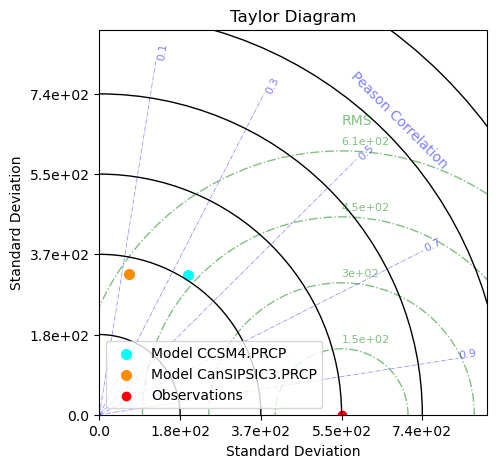

In [5]:
means = xr.concat([i.mean('M') for i in models], 'M').assign_coords({'M':gcms})
xc.view_taylor(means, Y)

### Plot Spatial Patterns

OBSERVATIONS


/var/folders/m6/v31d2h_s0tzc6pn_nvz43mrr0000gp/T/ipykernel_50196/1493964742.py:6: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in pl.axes.flat:


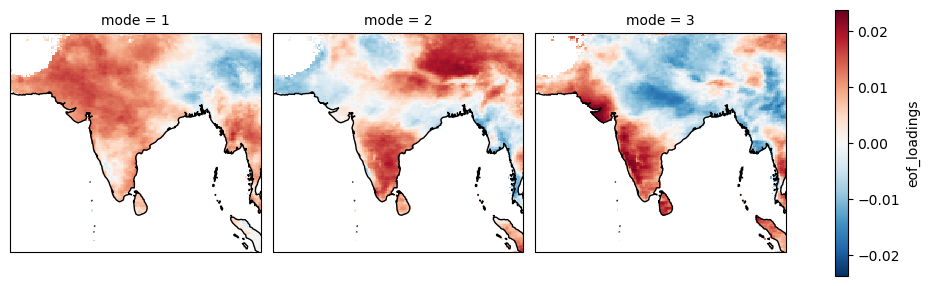

CCSM4.PRCP


/var/folders/m6/v31d2h_s0tzc6pn_nvz43mrr0000gp/T/ipykernel_50196/1493964742.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in pl.axes.flat:


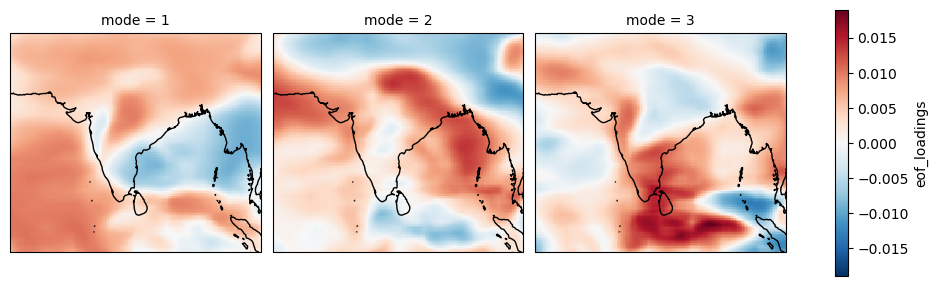

CanSIPSIC3.PRCP


/var/folders/m6/v31d2h_s0tzc6pn_nvz43mrr0000gp/T/ipykernel_50196/1493964742.py:15: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in pl.axes.flat:


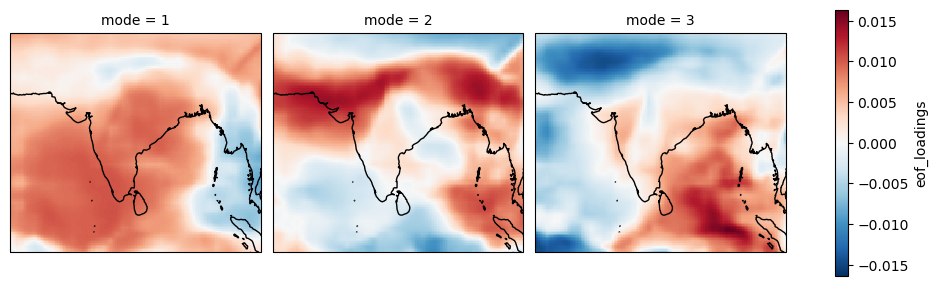

In [6]:
modes = 3
print('OBSERVATIONS')
eof = xc.EOF(latitude_weighting=True)
eof.fit(Y)
pl = eof.eof_loadings.isel(mode=slice(0, modes)).plot(subplot_kws={'projection':ccrs.PlateCarree()}, col="mode", col_wrap=modes)
for ax in pl.axes.flat:
    ax.coastlines()
plt.show()
    
for i, model in enumerate(models): 
    print('{}'.format(gcms[i]))
    eof = xc.EOF(latitude_weighting=True)
    eof.fit(model.mean('M').expand_dims({'M':[0]}))
    pl = eof.eof_loadings.isel(mode=slice(0, modes)).plot(subplot_kws={'projection':ccrs.PlateCarree()}, col="mode", col_wrap=modes)
    for ax in pl.axes.flat:
        ax.coastlines()
    plt.show()

### Plot Deterministic Skill Scores

/var/folders/m6/v31d2h_s0tzc6pn_nvz43mrr0000gp/T/ipykernel_50196/2024027888.py:11: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in pl.axes.flat:
/var/folders/m6/v31d2h_s0tzc6pn_nvz43mrr0000gp/T/ipykernel_50196/2024027888.py:23: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in pl.axes.flat:
/var/folders/m6/v31d2h_s0tzc6pn_nvz43mrr0000gp/T/ipykernel_50196/2024027888.py:35: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in pl.axes.flat:
/Users/khall/Desktop/xcast/src/verification/flat_metrics.py:107: RuntimeWarning: Mean of empty slice
  return np.nanmean(predicted) / np.nanmean(observed)
/Users/khall/Desktop/xcast/src/verification/flat_metrics.py:107: RuntimeWarning: Mean of empty slice
  return np.nanmean(predicted)

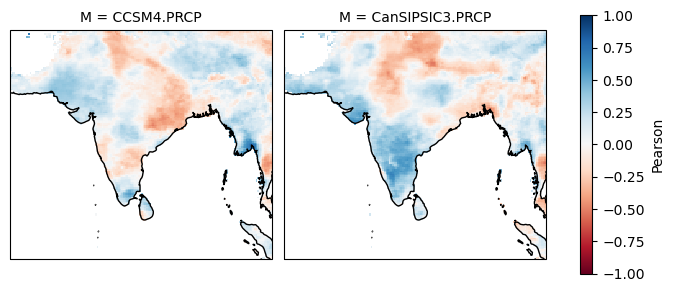

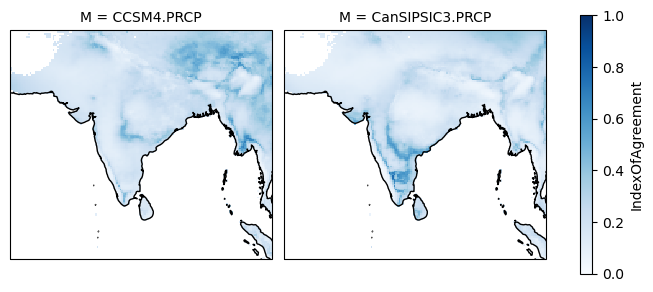

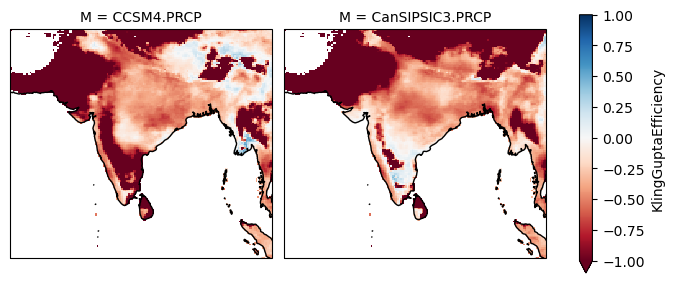

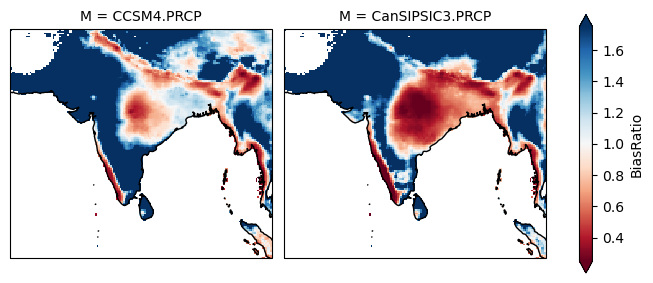

In [7]:
if len(models) > 1:
    pearsons = []
    for model in models: 

        pearson = xc.Pearson(model.mean('M').expand_dims({'M':[0]}), Y)
        pearsons.append(pearson)

    pearsons = xr.concat(pearsons, 'M').assign_coords({'M': gcms})

    pl = pearsons.plot(col='M', col_wrap=2, cmap='RdBu', vmin=-1, vmax=1,  subplot_kws={'projection': ccrs.PlateCarree()})
    for ax in pl.axes.flat:
        coasts = ax.coastlines()

    ioas = []
    for model in models: 

        ioa = xc.IndexOfAgreement(model.mean('M').expand_dims({'M':[0]}), Y)
        ioas.append(ioa)

    ioas = xr.concat(ioas, 'M').assign_coords({'M': gcms})

    pl = ioas.plot(col='M', col_wrap=2, cmap='Blues', vmin=0, vmax=1, subplot_kws={'projection': ccrs.PlateCarree()})
    for ax in pl.axes.flat:
        coasts = ax.coastlines()

    kges = []
    for model in models: 

        kge = xc.KlingGuptaEfficiency(model.mean('M').expand_dims({'M':[0]}), Y)
        kges.append(kge)

    kges = xr.concat(kges, 'M').assign_coords({'M': gcms})

    pl = kges.plot(col='M', col_wrap=2, cmap='RdBu', vmin=-1, vmax=1, subplot_kws={'projection': ccrs.PlateCarree()})
    for ax in pl.axes.flat:
        coasts = ax.coastlines() 

    brs = []
    for model in models: 

        br = xc.BiasRatio(model.mean('M').expand_dims({'M':[0]}), Y)
        brs.append(br)

    brs = xr.concat(brs, 'M').assign_coords({'M': gcms})

    pl = brs.plot(col='M', col_wrap=2, cmap='RdBu', vmin=0.25, vmax=1.75,subplot_kws={'projection': ccrs.PlateCarree()})
    for ax in pl.axes.flat:
        coasts = ax.coastlines() 
else:
    pearson = xc.Pearson(models[0].mean('M').expand_dims({'M':[0]}), Y)
    pl = pearson.plot(cmap='RdBu', vmin=-1, vmax=1,  subplot_kws={'projection': ccrs.PlateCarree()})
    pl.axes.coastlines()
    plt.show()
    
    ioa = xc.IndexOfAgreement(models[0].mean('M').expand_dims({'M':[0]}), Y)
    pl = ioa.plot(cmap='Blues', vmin=0, vmax=1, subplot_kws={'projection': ccrs.PlateCarree()})
    pl.axes.coastlines()
    plt.show()
    
    kge = xc.KlingGuptaEfficiency(models[0].mean('M').expand_dims({'M':[0]}), Y)
    pl = kge.plot(cmap='RdBu', vmin=-1, vmax=1, subplot_kws={'projection': ccrs.PlateCarree()})
    pl.axes.coastlines()
    plt.show()
    
    br = xc.BiasRatio(models[0].mean('M').expand_dims({'M':[0]}), Y)
    pl = br.plot(cmap='RdBu', vmin=0.25, vmax=1.75,subplot_kws={'projection': ccrs.PlateCarree()})
    pl.axes.coastlines()
    plt.show()






# Cross-Validation

In [8]:
model_pr_hcsts, estimators = [], []
for n, model in enumerate(models):
    prob_model = []
    i =1
    start = dt.datetime.now()
    for x_train, y_train, x_test, y_test in xc.CrossValidator(model, Y, window=1):
        print('Cross Validation Window {} for {} - {}'.format(i, gcms[n], dt.datetime.now() - start ), end='\r')
        i+=1
        mc = ESTIMATOR()
        mc.fit(x_train, y_train)
        probs = mc.predict_proba(x_test)
        prob_model.append(probs)
    print()
    prob_model=xr.concat(prob_model, 'T')
    model_pr_hcsts.append(prob_model)
    
    est = ESTIMATOR()
    est.fit(model, Y)
    estimators.append(est)
    
    


Cross Validation Window 30 for CCSM4.PRCP - 0:02:16.950147
Cross Validation Window 30 for CanSIPSIC3.PRCP - 0:02:20.847423


# Evaluate Probabilistic Forecasts 

/Users/khall/Desktop/xcast/src/verification/flat_metrics.py:56: RuntimeWarning: invalid value encountered in divide
  hit_scores = numerators / denominators
/Users/khall/Desktop/xcast/src/verification/flat_metrics.py:56: RuntimeWarning: invalid value encountered in divide
  hit_scores = numerators / denominators
/var/folders/m6/v31d2h_s0tzc6pn_nvz43mrr0000gp/T/ipykernel_50196/687108916.py:23: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in pl.axes.flat:
/var/folders/m6/v31d2h_s0tzc6pn_nvz43mrr0000gp/T/ipykernel_50196/687108916.py:39: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in pl.axes.flat:
/var/folders/m6/v31d2h_s0tzc6pn_nvz43mrr0000gp/T/ipykernel_50196/687108916.py:54: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
 

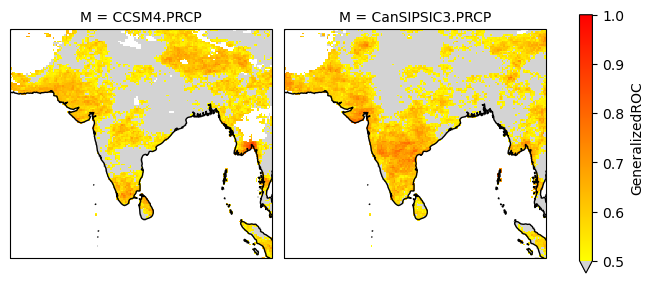

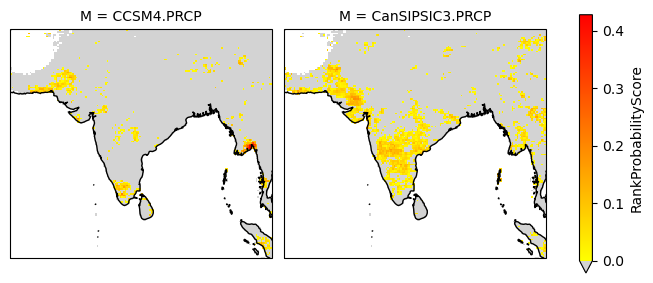

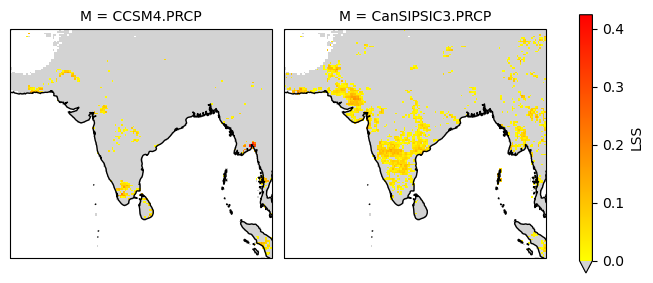

In [9]:
import matplotlib.pyplot as plt 

# compute ground truth terciles 
rt = xc.RankedTerciles() 
rt.fit(Y)
T = rt.transform(Y)

climo_rps = xc.RankProbabilityScore(xr.ones_like(T) * 0.333, T)

cmapg = plt.get_cmap('autumn_r').copy()
cmapg.set_under('lightgray')

if len(model_pr_hcsts) > 1:
    grocs = []
    for membercount in model_pr_hcsts: 

        groc = xc.GeneralizedROC(membercount, T)
        grocs.append(groc)

    grocs = xr.concat(grocs, 'M').assign_coords({'M': gcms})

    pl = grocs.plot(col='M', col_wrap=len(gcms), cmap=cmapg, vmin=0.5, vmax=1, subplot_kws={'projection': ccrs.PlateCarree()})
    for ax in pl.axes.flat:
        coasts = ax.coastlines()

    rpsss = []
    for membercount in model_pr_hcsts: 

        rps = xc.RankProbabilityScore(membercount, T)
        rpss = 1 - (rps / climo_rps)
        rpsss.append(rpss)

    rpsss = xr.concat(rpsss, 'M').assign_coords({'M': gcms})

    cmap = plt.get_cmap('autumn_r').copy()
    cmap.set_under('lightgray')

    pl = rpsss.plot(col='M', col_wrap=len(gcms), cmap=cmap, vmin=0,  subplot_kws={'projection': ccrs.PlateCarree()})
    for ax in pl.axes.flat:
        coasts = ax.coastlines()


    owlss = []
    for membercount in model_pr_hcsts: 
        owls = xc.LSS(membercount, T)
        owlss.append(owls)

    owlss = xr.concat(owlss, 'M').assign_coords({'M': gcms})

    cmap = plt.get_cmap('autumn_r').copy()
    cmap.set_under('lightgray')

    pl = owlss.plot(col='M', col_wrap=len(gcms), cmap=cmap, vmin=0, subplot_kws={'projection': ccrs.PlateCarree()})
    for ax in pl.axes.flat:
        coasts = ax.coastlines()
else: 
    groc = xc.GeneralizedROC(model_pr_hcsts[0], T).mean('M')
    pl = groc.plot(cmap=cmapg, vmin=0.5, vmax=1, subplot_kws={'projection': ccrs.PlateCarree()})
    pl.axes.coastlines()
    plt.show() 
    
    rps = xc.RankProbabilityScore(model_pr_hcsts[0], T)
    rpss = 1 - (rps / climo_rps)
    pl = rpss.plot(cmap=cmapg, vmin=0,  subplot_kws={'projection': ccrs.PlateCarree()})
    pl.axes.coastlines()
    plt.show() 
    
    lss = xc.LSS(model_pr_hcsts[0], T)
    pl = lss.plot(cmap=cmapg, vmin=0, subplot_kws={'projection': ccrs.PlateCarree()})
    pl.axes.coastlines()
    plt.show()



    



RECIEVER OPERATING CHARACTERISTICS (WHEN GROC > 0.5) FOR CCSM4.PRCP


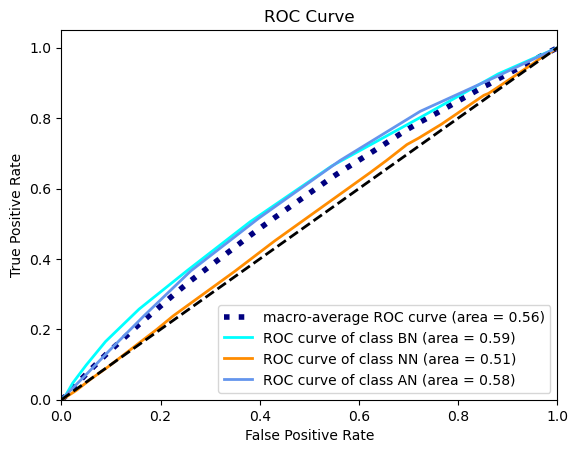

RECIEVER OPERATING CHARACTERISTICS (WHEN GROC > 0.5) FOR CanSIPSIC3.PRCP


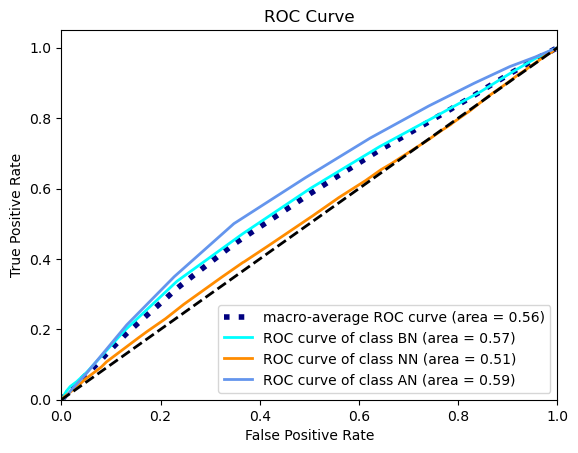

In [10]:
use_mask = True
for i, mc in enumerate(model_pr_hcsts):
    print('RECIEVER OPERATING CHARACTERISTICS (WHEN GROC > 0.5) FOR {}'.format(gcms[i]) if use_mask else 'RECIEVER OPERATING CHARACTERISTIC (ALL POINTS) FOR {}'.format(gcms[i]))
    groc = grocs.sel(M=gcms[i]) if len(model_pr_hcsts) > 1 else groc
    mask = xr.ones_like(groc).where(groc > 0.5, other=np.nan).mean('SKILLDIM')
    xc.view_roc(mc * mask if use_mask else mc, T)
    plt.show()

RELIABILITY (WHEN GROC > 0.5) FOR CCSM4.PRCP


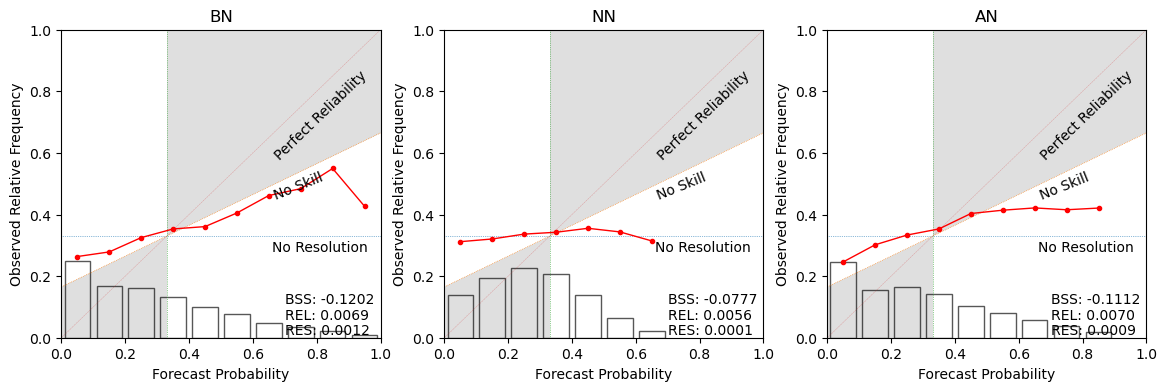

RELIABILITY (WHEN GROC > 0.5) FOR CanSIPSIC3.PRCP


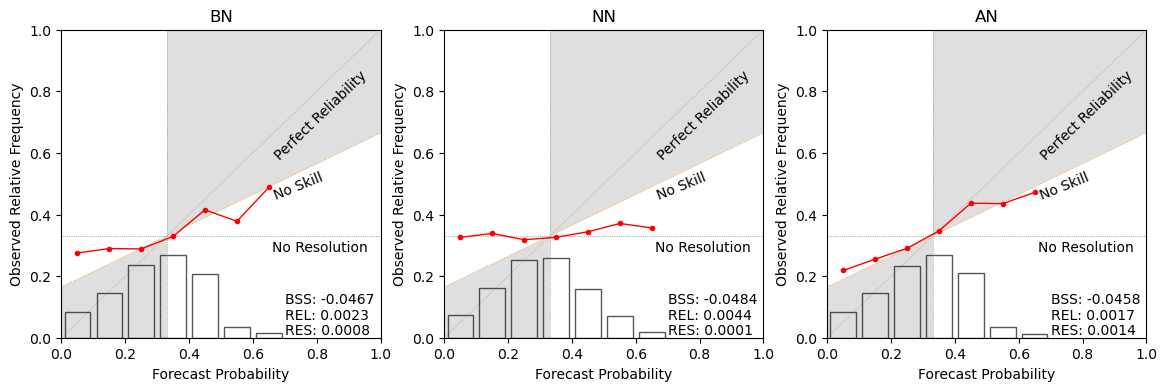

In [11]:
use_mask=True
for i, mc in enumerate(model_pr_hcsts):
    print('RELIABILITY (WHEN GROC > 0.5) FOR {}'.format(gcms[i]))
    groc = grocs.sel(M=gcms[i])  if len(model_pr_hcsts) > 1 else groc
    mask = xr.ones_like(groc).where(groc > 0.5, other=np.nan).mean('SKILLDIM')
    xc.view_reliability(mc * mask if use_mask else mc, T)
    plt.show()

# Out-Of-Sample Forecasts

Raw Anomaly Forecast from CCSM4.PRCP for 2022-05-01 00:00:00


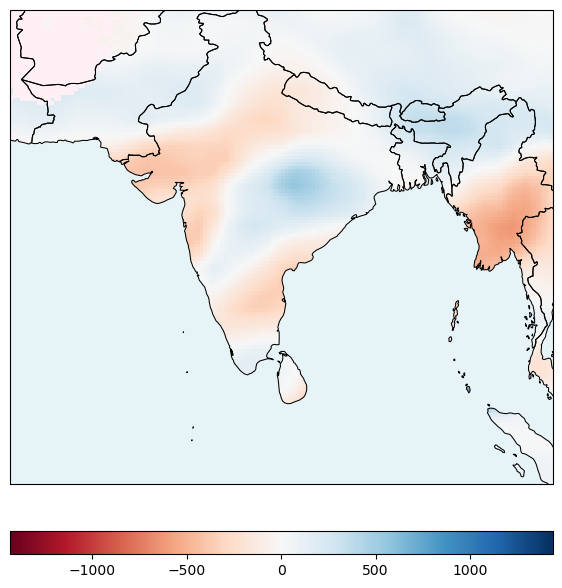

Bias-Corrected Tercile Probability Forecast from CCSM4.PRCP for 2022-05-01 00:00:00


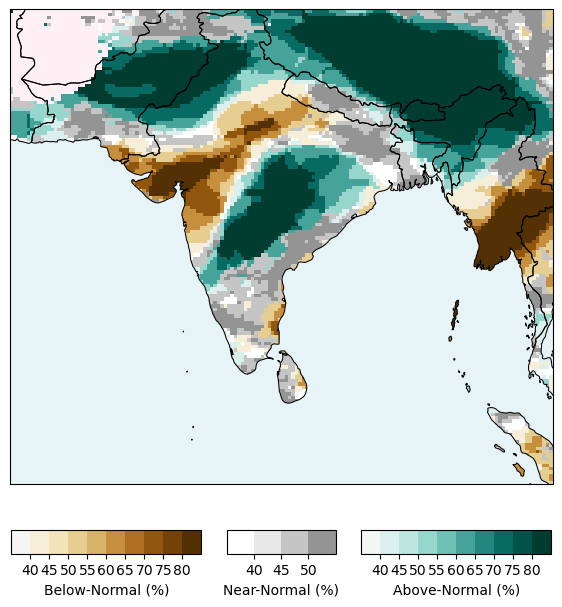

Raw Anomaly Forecast from CanSIPSIC3.PRCP for 2022-05-01 00:00:00


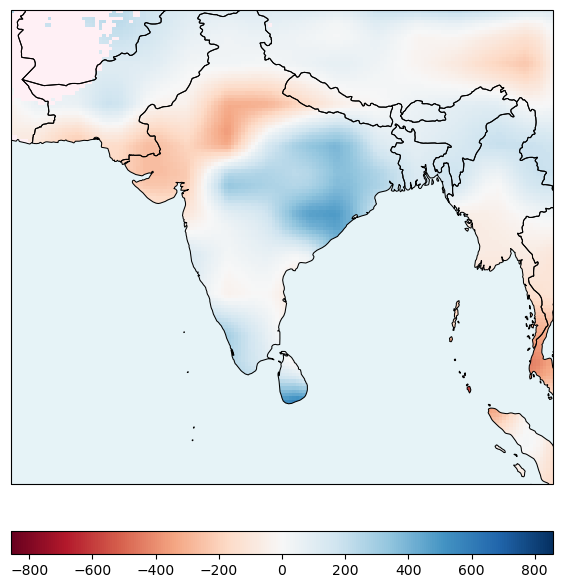

Bias-Corrected Tercile Probability Forecast from CanSIPSIC3.PRCP for 2022-05-01 00:00:00


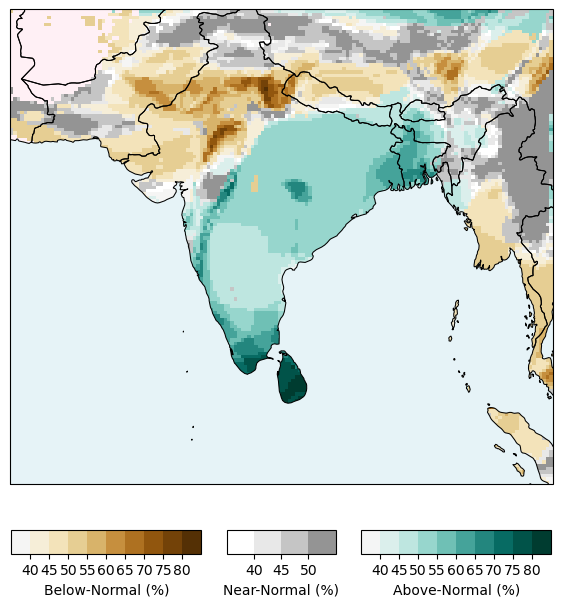

In [12]:
for i, est in enumerate(estimators):
    print('Raw Anomaly Forecast from {} for {}'.format(gcms[i], download_args['fdate']))
    det = fcsts[i] - models[i].mean('T')
    xc.view(det.isel(T=-1, M=-1), drymask=drymask, cmap='RdBu')
    plt.show() 
    
    print('Bias-Corrected Tercile Probability Forecast from {} for {}'.format(gcms[i], download_args['fdate']))
    prob = est.predict_proba(fcsts[i])
    xc.view_probabilistic(prob.isel(T=-1), drymask=drymask)
    plt.show()
    